<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S14-15/EVA4_S15A_gen_fg_bg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount and Fetch Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile

path_to_zip_file = "/content/gdrive/My Drive/EVA4-Workspace/persons_fg/gen_fg_bg.zip"
directory_to_extract_to = '/content/'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/gen_fg_bg.zip
Extracted at: /content/


## Utils and Initialization


Utils to process raw data downloaded from the internet


*   Resize bg into 224*224
*   Rescale fg and fg_mask into h=105 and scale down width accordingly
*   Rename the data

This was executed locally and the processed data was stored in the drive as "**gen_fg_bg.zip**"


In [0]:
import os, sys
from PIL import Image
import numpy as np

def sizes(l):
	l.sort()
	sizes = []
	for infile in l:
		try:
			im = Image.open(infile)
			print(infile, im.size)
			sizes.append([infile, im.size])
		except Exception as e:
			print("Err: %s" % e)
	return sizes

def thumbnail(l, fmt="JPEG"):
	l.sort()
	size = 105, 105
	for infile in l:
		try:
			im = Image.open(infile)
			base_w, base_h = im.size
			new_h = 105
			hpercent = float(base_h)/float(new_h)
			new_w = int(float(base_w)*float(hpercent))
			im.thumbnail((new_w, new_h), Image.ANTIALIAS)
			im.save(infile, fmt)
		except IOError:
			print("cannot create thumbnail for '%s'" % infile)

def rename(l, tag, ext="jpg"):
	l.sort()
	for idx, src in enumerate(l):
		dst = f"{tag}_{idx:02d}.{ext}"
		os.rename(src, dst)

def reshape(l):
	size = 224, 224
	for infile in l:
		try:
			im = Image.open(infile)
			im = im.resize(size, Image.LANCZOS)
			im.save(infile, "JPEG")
		except IOError:
			print("cannot resize '%s'" % infile)

def preprocess():
	base_dir = os.getcwd()
	
	mdir = f"{base_dir}/bg/"
	os.chdir(mdir)
	l = os.listdir(".")
	# sm = sizes(l)
  reshape(l)
	rename(l, "bg", "jpg")

	mdir = f"{base_dir}/fg_mask/"
	os.chdir(mdir)
	l = os.listdir(".")
	# sm = sizes(l)
	thumbnail(l, "JPEG")
	rename(l, "fg", "jpg")

	mdir = f"{base_dir}/fg/"
	os.chdir(mdir)
	l = os.listdir(".")
	# sf = sizes(l)
	thumbnail(l, "PNG")
	rename(l, "fg", "png")


## Overlay Foreground on Background

Utils to overlay foreground on background and create its mask also


*   Each foreground is flipped horizontally
*   For each orientation of foreground, randomly overlay it on the background 20 times.
*   #bg = 100
*   #fg = 100
*   #fg_bg = 100\*100\*2\*20 = 400,000



In [0]:
from zipfile import ZipFile, ZIP_STORED
import io

def overlay_fg_on_bg():
	bg_dir = "./bg/"
	bg_imgs = sorted(os.listdir(bg_dir))
	fg_dir = "./fg/"
	fg_imgs = sorted(os.listdir(fg_dir))
	fg_masks_dir = "./fg_mask/"
	assert(len(bg_imgs) == 100)
	assert(len(fg_imgs) == 100)
	for bidx, bg_img in enumerate(bg_imgs):
		out_zip = ZipFile('fg_bg.zip', mode='a', compression=ZIP_STORED)
		label_info = open(f'fg_bg_labels.txt', 'w+')
		idx = 4000 * bidx
		print(f'Processing BG {bidx}')
		mbg = Image.open(bg_dir + bg_img)
		for fidx, fg_img in enumerate(fg_imgs):
			mfg = Image.open(fg_dir + fg_img)
			assert(fg_img[-4:] == ".png")
			mfg_mask = Image.open(fg_masks_dir + fg_img[:-4] + ".jpg")
			
			for i in range(20):
				
				for should_flip in [True, False]:
					bg = mbg.copy()
					fg = mfg.copy()
					fg_mask = mfg_mask.copy()

					if should_flip:
						fg = fg.transpose(Image.FLIP_LEFT_RIGHT)
						fg_mask = fg_mask.transpose(Image.FLIP_LEFT_RIGHT)

					bg_w, bg_h = bg.size
					fg_w, fg_h = fg.size
					max_h = bg_h - fg_h
					max_w = bg_w - fg_w
					pos_x = np.random.randint(low=0, high=max_w, size=1)[0]
					pos_y = np.random.randint(low=0, high=max_h, size=1)[0]

					bg.paste(fg, (pos_x, pos_y), fg)

					bg_mask = Image.new('L', bg.size)
					fg_mask = fg_mask.convert('L')
					bg_mask.paste(fg_mask, (pos_x, pos_y), fg_mask)

					bg.save('b_temp.jpg', optimize=True, quality=65)
					bg_mask.save('m_temp.jpg', optimize=True, quality=65)
					
					out_zip.write('b_temp.jpg', f'fg_bg/{bg_img[:-4]}/{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg')
					out_zip.write('m_temp.jpg', f'fg_bg_masks/{bg_img[:-4]}/{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg')
					label_info.write(f'{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg\t{pos_x}\t{pos_y}\n')

					idx += 1
		
		label_info.close()
		out_zip.write('fg_bg_labels.txt', f'labels/{bg_img[:-4]}_label_info.txt')
		out_zip.close()


Generate the fg_bg images and masks

In [0]:
overlay_fg_on_bg()

Processing BG 0
Processing BG 1
Processing BG 2
Processing BG 3
Processing BG 4
Processing BG 5
Processing BG 6
Processing BG 7
Processing BG 8
Processing BG 9
Processing BG 10
Processing BG 11
Processing BG 12
Processing BG 13
Processing BG 14
Processing BG 15
Processing BG 16
Processing BG 17
Processing BG 18
Processing BG 19
Processing BG 20
Processing BG 21
Processing BG 22
Processing BG 23
Processing BG 24
Processing BG 25
Processing BG 26
Processing BG 27
Processing BG 28
Processing BG 29
Processing BG 30
Processing BG 31
Processing BG 32
Processing BG 33
Processing BG 34
Processing BG 35
Processing BG 36
Processing BG 37
Processing BG 38
Processing BG 39
Processing BG 40
Processing BG 41
Processing BG 42
Processing BG 43
Processing BG 44
Processing BG 45
Processing BG 46
Processing BG 47
Processing BG 48
Processing BG 49
Processing BG 50
Processing BG 51
Processing BG 52
Processing BG 53
Processing BG 54
Processing BG 55
Processing BG 56
Processing BG 57
Processing BG 58
Process

Save the generated images to Google Drive

In [0]:
!cp "/content/fg_bg.zip" "/content/gdrive/My Drive/EVA4-Workspace/persons_fg/"

In [0]:
import zipfile

path_to_zip_file = "/content/fg_bg.zip"
directory_to_extract_to = '/content/'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/fg_bg.zip
Extracted at: /content/


### Data Visualization

Visualize the generated data

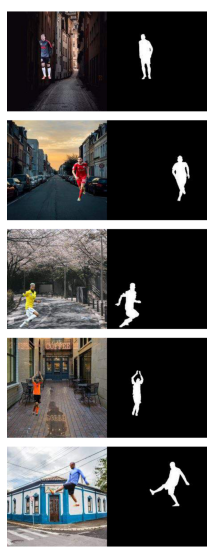

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob

img_paths = []
for i in range(5):
  f = glob.glob(f"/content/fg_bg/bg_0{i}/*jpg")[0]
  img_paths.append(f)
  img_paths.append(f.replace("fg_bg","fg_bg_masks"))

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array():
    return np.array([np.asarray(ImageOps.expand(
        Image.open(f).convert('RGB'), border=(0, 10), fill='white')) for f in img_paths])

array = make_array()
result = gallery(array)
plt.figure(figsize=(22,10))
plt.axis("off")
plt.imshow(result)
plt.show()